In [1]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

### Agent 

We simply can re-use the components we've already built.

In [2]:
%%writefile ../src/deep_research_from_scratch/tavily_deep_research_agent.py

"""
Full Multi-Agent Research System

This module integrates all components of the research system:
- User clarification and scoping
- Research brief generation  
- Multi-agent research coordination
- Final report generation

The system orchestrates the complete research workflow from initial user
input through final report delivery.
"""

from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END

from deep_research_from_scratch.utils import get_today_str
from deep_research_from_scratch.prompts import final_report_generation_prompt
from deep_research_from_scratch.state_scope import AgentState, AgentInputState
from deep_research_from_scratch.research_agent_scope import clarify_with_user, write_research_brief, parse_success_criteria
from deep_research_from_scratch.multi_agent_supervisor import supervisor_agent
from deep_research_from_scratch.research_agent import researcher_agent

# ===== Config =====

from langchain.chat_models import init_chat_model
writer_model = init_chat_model(model="openai:gpt-4.1", max_tokens=32000) # model="anthropic:claude-sonnet-4-20250514", max_tokens=64000

# ===== FINAL REPORT GENERATION =====

from deep_research_from_scratch.state_scope import AgentState

def run_researcher_agent(state: AgentState):
    """Bridge node that runs the researcher subgraph after scoping."""

    research_topic = state.get("research_brief", "")
    criteria = state.get("success_criteria", {})
    supervisor_msgs = state.get("supervisor_messages", [])

    researcher_input = {
        "researcher_messages": supervisor_msgs,
        "tool_call_iterations": 0,
        "research_topic": research_topic,
        "compressed_research": "",
        "raw_notes": [],
        "success_criteria": criteria,
    }

    research_output = researcher_agent.invoke(researcher_input)

    return {
        "raw_notes": research_output.get("raw_notes", []),
        "supervisor_messages": research_output.get("researcher_messages", []),
        "final_report": research_output.get("compressed_research", ""),
        "success_criteria": research_output.get("success_criteria", criteria),
    }

async def final_report_generation(state: AgentState):
    """
    Final report generation node.
    
    Synthesizes all research findings into a comprehensive final report
    """
    
    notes = state.get("notes", [])
    
    findings = "\n".join(notes)

    final_report_prompt = final_report_generation_prompt.format(
        research_brief=state.get("research_brief", ""),
        findings=findings,
        date=get_today_str()
    )
    
    final_report = await writer_model.ainvoke([HumanMessage(content=final_report_prompt)])
    
    return {
        "final_report": final_report.content, 
        "messages": ["Here is the final report: " + final_report.content],
    }

# ===== GRAPH CONSTRUCTION =====
# Build the overall workflow
deep_researcher_builder = StateGraph(AgentState, input_schema=AgentInputState)

# ===== Add workflow nodes =====
deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)
deep_researcher_builder.add_node("parse_success_criteria", parse_success_criteria)
deep_researcher_builder.add_node("run_researcher_agent", run_researcher_agent)
deep_researcher_builder.add_node("final_report_generation", final_report_generation)

# ===== Connect the edges =====
deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("clarify_with_user", "write_research_brief")
deep_researcher_builder.add_edge("write_research_brief", "parse_success_criteria")
deep_researcher_builder.add_edge("parse_success_criteria", "run_researcher_agent")
deep_researcher_builder.add_edge("run_researcher_agent", "final_report_generation")
deep_researcher_builder.add_edge("final_report_generation", END)

# ===== Compile the full workflow =====
agent = deep_researcher_builder.compile()


Overwriting ../src/deep_research_from_scratch/tavily_deep_research_agent.py


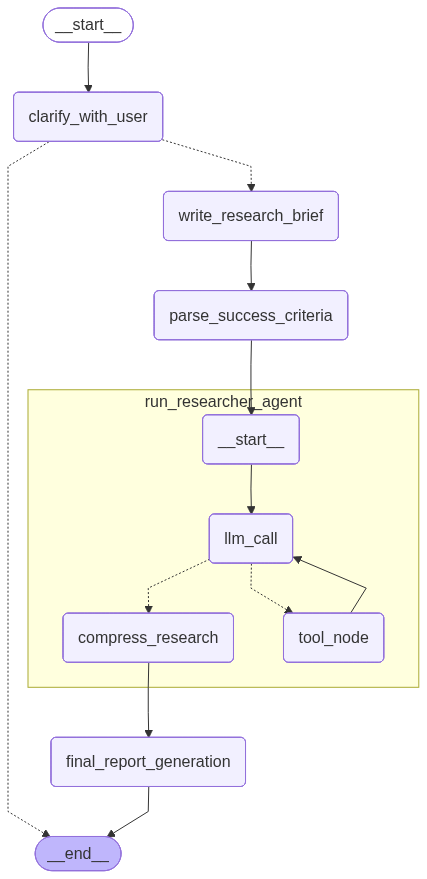

In [3]:
# Run the workflow
from utils import format_messages
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
from deep_research_from_scratch.tavily_deep_research_agent import deep_researcher_builder

checkpointer = InMemorySaver()
full_agent = deep_researcher_builder.compile(checkpointer=checkpointer)
display(Image(full_agent.get_graph(xray=True).draw_mermaid_png()))

In [7]:
from langchain_core.messages import AIMessage, HumanMessage

conversation_1 = [
    HumanMessage(content="What's the best way to invest $50,000 for retirement?"),
    AIMessage(content="Could you please provide some additional information to tailor the investment advice for your $50,000 retirement goal? Specifically:\n Your current age or desired retirement age\n Your risk tolerance (low, medium, high)\n Any preferences for investment types (e.g., stocks, bonds, mutual funds, real estate)\n Whether you are investing through a tax-advantaged account (e.g., IRA, 401(k)) or a regular brokerage account\n This will help me provide more personalized and relevant suggestions."),
    HumanMessage(content="I'm 25 and I want to retire by 45. My risk tolerance is high right now but I think will decrease over time. I have heard that stocks and ETFs are a good choice, but I'm open to anything. And I already have a 401k, but this would just be through a regular brokerage account."),
]

conversation_2 = [
    HumanMessage(content="I am looking for an apartment in NYC, can you help me?"),
    AIMessage(content="Could you please specify your apartment preferences? For example:\n Desired neighborhoods or boroughs\n Number of bedrooms/bathrooms\n Budget range (monthly rent)\n Any amenities or must-have features\n Preferred move-in date\n This information will help me provide the most relevant apartment options in NYC."),
    HumanMessage(content="I'd prefer to live in Chelsea, Flatiron, or West Village. I'm looking for a 2 bed 2 bath, and I am looking for monthly rent below 7k. I'd like this to be a doorman building and have an in unit washer and dryer, but it's okay if there's no washer dryer. It's a plus if the building has a gym. And I'd like to move in in September 2025."),
]

conversation_3 = [
    HumanMessage(content="I’ll be in Toronto on Nov 7 to 14, what are some must-see events, seasonal experiences, or festivals during that time? Please include official links and tips for visitors."),
    AIMessage(content="Could you please tell me a bit more so I can tailor the recommendations?\n- What kind of experiences do you enjoy (e.g., food festivals, art exhibits, live music, sports, cultural events)?\n- Will you have access to a car, or are you planning to rely mainly on public transit or walking?\n- Do you prefer outdoor seasonal attractions or indoor activities?\nOnce I know these details, I can find verified events with official booking links and practical visitor tips."),
    HumanMessage(content="I’ll mostly rely on public transit or walking. I enjoy live music, unique seasonal experiences, and cultural festivals. I’d also love to see any big art or light exhibits during that week."),
]

conversation_4 = [
    HumanMessage(content="How is IBM watsonx Orchestrate built? What technologies does it use – exactly what APIs, is it using LangGraph? Langfuse? Langflow?"),
    AIMessage(content="To provide an accurate and detailed answer, could you clarify a few things:\n- Are you asking about the overall architecture of watsonx Orchestrate as a product, or its underlying orchestration and agent runtime layer?\n- Do you want a breakdown of specific frameworks and APIs used internally (e.g., LangGraph, LangChain, or proprietary IBM tools)?\n- Should I focus on public technical documentation or internal IBM developer architecture details?\nThis will help me tailor the explanation to the level of depth you want."),
    HumanMessage(content="I’m interested in the underlying architecture — specifically how the orchestration and agent runtime works. I want to know which frameworks it integrates with and whether LangGraph, Langfuse, or Langflow are actually part of it."),
]

conversation_5 = [
    HumanMessage(content="What is weed made of? Isn't it just a plant? How can it get us high?"),
]

In [ ]:
thread = {"configurable": {"thread_id": "1"}}

for message_chunk, metadata in full_agent.stream(
    {"messages": conversation_2},
    stream_mode="messages",
    config=thread,
):
    if message_chunk.content:
        print(message_chunk.content, end="|", flush=True)

In [8]:
from langchain_core.messages import HumanMessage
thread = {"configurable": {"thread_id": "1", "recursion_limit": 50}}
result = await full_agent.ainvoke({"messages": conversation_5}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ What is weed made of? Isn't it just a plant? How can it get us high?                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Thank you for your question. You are asking about what weed (cannabis) is made of, why it is considered 'just a │
│ plant,' and how it can cause psychoactive effects (get people high). I have enough information to proceed and   │
│ will now begin researching and preparing a detailed explanation addressing these points.                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Here is the final report: # Understanding Cannabis: Composition, Psychoactive Mechanism, and Botanical          │
│ Uniqueness                                                                                                      │
│                                                                                                                 │
│ ## Overview of Cannabis as a Plant                                                                              │
│                                                                                                                 │
│ Cannabis is a flowering plant belonging to the family Cannabaceae. Botanically, it is classified under the      │
│ genus *Cannabis*, with the most widely recognized species being *Cannabis sativa*, *Cannabis indica*, and, to a │
│ lesser extent, *Cannabis ruderalis*[^1]. Cannabis is indigenous to Central Asia but now grows worldwide. As a   │
│ plant, it reproduces with seeds and displays the core features of angiosperms (flowering plants), such as       │
│ stems, leaves, flowers, and roots.                                                                              │
│                                                                                                                 │
│ Cannabis is cultivated for a range of uses:                                                                     │
│ - **Fiber and seeds:** Industrial hemp (a variety of *Cannabis sativa* with low tetrahydrocannabinol, THC) is   │
│ grown for fiber, seeds, and oils.                                                                               │
│ - **Medicinal and recreational use:** Other varieties are cultivated for their psychoactive constituents.       │
│                                                                                                                 │
│ ### Botanical Distinction                                                                                       │
│                                                                                                                 │
│ Not every plant contains compounds that affect human perception or consciousness. Cannabis's uniqueness among   │
│ plants lies in its production of specific chemical compounds—most notably cannabinoids—that interact directly   │
│ with the human nervous system, a capability not commonly found in most plants[^1].                              │
│                                                                                                                 │
│ ## Major Chemical Constituents of Cannabis                                                                      │
│                                                                                                                 │
│ The psychoactive and physiological effects of cannabis are products of its unique chemical composition. The     │
│ primary and best-studied compounds are:                                                                         │
│                                                                                                                 │
│ ### Cannabinoids                                                                                                │
│                                                                                                                 │
│ - **Tetrahydrocannabinol (THC):** The main psychoactive compound. THC binds directly to specific receptors in   │
│ the human brain, producing the sensation commonly described as being "high"[^2].                                │
│ - **Cannabidiol (CBD):** Non-psychoactive in the traditional sense, CBD does not produce a high. It is of major │
│ therapeutic interest due to its potential anxiolytic, anti-inflammatory, and anti-seizure effects[^3]. The      │
│ World Health Organization has stated that CBD shows no 

In [ ]:
result = await full_agent.ainvoke({"messages": [HumanMessage(content="Yes the specific Deep Research products.")]}, config=thread)

In [ ]:
format_messages(result['messages'])

In [ ]:
from rich.markdown import Markdown
Markdown(result["final_report"])

We can see the trace [here](https://smith.langchain.com/public/86ebdc25-4595-4040-be1e-a8e30052786b/r).

### LangGraph Studio

Just as we did before, we can also use LangGraph Studio to visualize the agent. 

The files we wrote with `%%writefile` to `src/deep_research_from_scratch/` during the all the notebooks create the files for our application:

```
deep_research_from_scratch/
├── src/deep_research_from_scratch/
│   ├── state.py          # State definitions
│   ├── scope_research.py # Scoping workflow
│   ├── prompts.py        # Prompt templates
│   └── ...
├── notebooks/            # Development notebooks
├── pyproject.toml        # Dependencies
└── langgraph.json        # LangGraph configuration
```

This agent has been added to the `langgraph.json` file, so you can select `research_agent_full` in the dropdown menu:

```
"research_agent_full": "./src/deep_research_from_scratch/research_agent_full.py:agent"
```

Run the following command to start the studio

```bash
uvx --refresh --from "langgraph-cli[inmem]" --with-editable . --python 3.11 langgraph dev --allow-blocking
```